In [1]:
import sys
import numpy as np
import scipy.stats
from itertools import product
import cvxpy as cp
from collections import Counter, defaultdict
import json
import argparse
import matplotlib.pyplot as plt

In [2]:
parser = argparse.ArgumentParser(description='Pull family genotype counts.')
parser.add_argument('data_dir', type=str, help='Directory of genotype data in .npy format.')
parser.add_argument('out_file', type=str, help='File to write parameters.')
parser.add_argument('--is_ngs', action='store_true', default=False, help='True if this data is NGS. The important point is whether or not sites where all individuals are homozygous reference are sometimes dropped from the VCF. If this happens, use flag --is_ngs')
parser.add_argument('--sample_names_have_dot', action='store_true', default=False, help='Do sample names sometimes contain a "."?')

args = parser.parse_args(['../split_gen_ihart', 'params/ihart_params.json', '--is_ngs'])

In [3]:
print(args.is_ngs)

True


# Basic Info

In [4]:
chroms = [str(x) for x in range(1, 23)] #+ ['X', 'Y'] 

# 0 = 0/0
# 1 = 0/1
# 2 = 1/1
# 3 = ./.
# 4 = -/0 (hemizygous ref)
# 5 = -/1 (hemizygous alt)
# 6 = -/- (double deletion)

errors = [(0, 1), (0, 2), (0, 3), 
          (1, 0), (1, 2), (1, 3), 
          (2, 0), (2, 1), (2, 3)]

error_to_index = dict([(x, i) for i, x in enumerate(errors)])
print('num error types', len(errors))

mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1),
    (0, 2, 1),
    (1, 0, 0), (1, 0, 1),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2),
    (2, 0, 1),
    (2, 1, 1), (2, 1, 2),
    (2, 2, 2)
}

mendelian_check = lambda x: x in mendelian_trios
allowable_errors_child = {
    (0, 1), (0, 2), (0, 3),
    (1, 0), (1, 2), (1, 3),
    (2, 0), (2, 1), (2, 3)
}
allowable_errors_parent = {
    (0, 2), (0, 3),
    (1, 0), (1, 2), (1, 3),
    (2, 0), (2, 3)
}

num error types 9


# Pull Data

In [5]:

family_chrom_to_counts = dict()
family_to_inds = dict()
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    with open('%s/chr.%s.famgen.counts.txt' % (args.data_dir, chrom), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            famkey, inds = pieces[:2]
            
            if args.sample_names_have_dot:
                # unfortunately, ssc uses . in their sample names
                inds = inds.split('.')
                inds = ['%s.%s' % (inds[i], inds[i+1]) for i in range(0, len(inds), 2)]
            else:
                inds = inds.split('.')

            m = len(inds)

            if m<=8:
                if famkey not in family_to_inds:
                    family_to_inds[famkey] = inds
                else:
                    assert family_to_inds[famkey] == inds
                
                counts = np.zeros((4,)*m, dtype=int)
                for g, c in zip(product([0, 1, 2, 3], repeat=m), pieces[2:]):
                    counts[g] = int(c)
                    
                family_chrom_to_counts[(famkey, chrom)] = counts

print('Families of each size', Counter([len(inds) for fkey, inds in family_to_inds.items()]))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families of each size Counter({4: 436, 5: 357, 6: 56, 3: 18, 7: 13, 8: 1})


In [6]:
# filter families that have all chroms
famkeys = []
for famkey in set([x[0] for x in family_chrom_to_counts.keys()]):
    has_chrom = np.array([(famkey, chrom) in family_chrom_to_counts for chrom in chroms])
    if np.sum(has_chrom) == len(chroms):
        famkeys.append(famkey)
    else:
        print('Missing chromosome counts', famkey, [chroms[i] for i in np.where(~has_chrom)[0]])
famkeys = sorted(famkeys)

print('Families', len(famkeys))

Families 881


# Poisson regression

In [7]:
def get_mendelian(ind_is_mendelian):
    
    # differentiate mendelian and non-mendelian famgens
    m = len(ind_is_mendelian)
    is_mendelian = np.ones((4,)*m, dtype=bool)
    for famgen in product([0, 1, 2, 3], repeat=m):
        is_mend = True
        for j in range(2, m):
            if not ind_is_mendelian[j](tuple(famgen[x] for x in [0, 1, j])):
                is_mend = False
        is_mendelian[famgen] = is_mend
    return is_mendelian

In [8]:
def has_variant(x):
    return len([y for y in x if y>0])>0

def estimate_error_rates(is_mendelian, allowable_errors, counts):
    
    # -------------------- set up problem --------------------
    nonmendelian_famgens = [x for x in zip(*np.where(~is_mendelian))]
    print('Mendelian', np.sum(is_mendelian), 'Nonmendelian', len(nonmendelian_famgens))
    
    if args.is_ngs:
        # if we're working with NGS data, we don't know the real counts of famgens without variants
        # because they may have been excluded from the vcf
        nonmendelian_famgens = [x for x in nonmendelian_famgens if has_variant(x)]

    m = len(counts.shape)
    X = np.zeros((len(nonmendelian_famgens), len(errors)*m))
    y = np.zeros((len(nonmendelian_famgens),))

    for k, nmfg in enumerate(nonmendelian_famgens):
        for i, j in product(range(4), range(m)):
            error = (i, nmfg[j])
            if error in allowable_errors[j]:
                neighbor = tuple(i if k==j else nmfg[k] for k in range(m))
                if is_mendelian[neighbor]:
                    error_index = error_to_index[error] + j*len(errors)
                    X[k, error_index] += counts[neighbor]
        y[k] = counts[nmfg]

        
    is_zero = np.sum(X, axis=0)==0
    print('Removing zero cols:', [(np.floor(i/len(errors)), errors[i % len(errors)]) for i in np.where(is_zero)[0]])
    X = X[:, ~is_zero]
    old_col_index_to_new = dict([(old_index, new_index) for new_index, old_index in enumerate(np.where(~is_zero)[0])])

    print('Removing zero rows:', np.sum(np.sum(X, axis=1)==0))
    indices = np.where(np.sum(X, axis=1) != 0)[0]
    X = X[indices, :]
    y = y[indices]
    
    print(X.shape, y.shape)
    
    # -------------------- solve problem --------------------
    
    print('Estimating...', X.shape, y.shape)
    alpha = 1.0/np.max(X)
    
    # cvxpy
    n = cp.Variable(X.shape[1])
    mu = np.sum(X, axis=0)
    objective = cp.Minimize(alpha*mu*n - alpha*y*cp.log(X*n))

    # rule of 3 so that if we don't observe any errors, then we take the 95% confidence interval
    z = 1.96
    constraints = [n>= ((z*z)/2)/(mu+(z*z)), n<=1]
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=100000)
    print(prob.status)
    
    #print(n.value, n.value.shape)
    ns = np.asarray([v for v in n.value])
    
    if prob.status != 'optimal' and prob.status != 'optimal_inaccurate':
        raise Error('Parameters not fully estimated.')
        
    # -------------------- reformat solution --------------------

    error_estimates = np.zeros((len(errors), len(inds)))
    error_estimates[:] = np.nan
    for k in range(len(errors)*len(inds)):
        if k in old_col_index_to_new:
            error_estimates[k%len(errors), int(np.floor(k/len(errors)))] = ns[old_col_index_to_new[k]]
    
    return error_estimates

In [9]:
def is_homref_neighbor(x):
    return len([y for y in x if y != 0])==1

def estimate_n(is_mendelian, allowable_errors, counts, error_rates, observed_homref):
    nonmendelian_famgens = [x for x in zip(*np.where(~is_mendelian)) if is_homref_neighbor(x)]
    print(nonmendelian_famgens)
    
    if args.is_ngs:
        # if we're working with NGS data, we don't know the real counts of famgens without variants
        # because they may have been excluded from the vcf
        nonmendelian_famgens = [x for x in nonmendelian_famgens if has_variant(x)]

    m = len(counts.shape)
    X = np.zeros((len(nonmendelian_famgens), 2))
    y = np.zeros((len(nonmendelian_famgens),))

    for k, nmfg in enumerate(nonmendelian_famgens):
        # we can't rely on sites with no variants to be included in the vcf
        for i, j in product(range(4), range(m)):
            error = (i, nmfg[j])
            if error in allowable_errors[j]:
                neighbor = tuple(i if k==j else nmfg[k] for k in range(m))
                if is_mendelian[neighbor]:
                    if neighbor == (0,)*m:
                        X[k, 1] = error_rates[error_to_index[error], j]
                    else:
                        X[k, 0] += error_rates[error_to_index[error], j] * counts[neighbor]
                        
        y[k] = counts[nmfg]
        
    print('Removing zero rows:', np.sum(np.sum(X, axis=1)==0))
    indices = np.where(np.sum(X, axis=1) != 0)[0]
    X = X[indices, :]
    y = y[indices]
    
    print(X.shape, y.shape)
    
    # -------------------- solve problem --------------------
    
    print('Estimating...', X.shape, y.shape)
    
    # cvxpy
    n = cp.Variable(X.shape[1])
    mu = np.sum(X, axis=0)
    objective = cp.Minimize(mu*n - y*cp.log(X*n))

    constraints = [n[0]==1, n[1]>=observed_homref]
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=100000)
    print(prob.status)
    
    #print(n.value, n.value.shape)
    ns = np.asarray([v for v in n.value])
    
    if prob.status != 'optimal' and prob.status != 'optimal_inaccurate':
        raise Error('Parameters not fully estimated.')
        
    print(ns)
    
    return ns[1]

In [26]:
famkey = famkeys[10]

In [104]:
inds = family_to_inds[famkey]
m = len(inds)
            
is_mendelian = get_mendelian([None, None] + ([mendelian_check]*(m-2)))
allowable_errors = [allowable_errors_parent]*2 + [allowable_errors_child]*(m-2)
counts = np.sum(np.array([family_chrom_to_counts[(famkey, chrom)] for chrom in chroms]), axis=0)

In [124]:
print(np.sum(counts))
s = tuple(0 if i==3 else slice(None, None, None) for i in range(m))
print(np.sum(counts[s]))

1004842172
1001302851


In [105]:
print(counts[(0,)*m])
homref=counts[(0,)*m]

64121401


In [106]:
error_estimates = estimate_error_rates(is_mendelian, allowable_errors, counts)
print(-np.log10(error_estimates))

Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[[       nan        nan 3.80036425 3.79271614 3.82853889]
 [5.6986693  5.86269923 5.67198182 5.72704067 5.92605174]
 [3.31573872 3.46088664 3.61229627 3.5495557  3.61408629]
 [2.40981785 2.31690258 3.11193602 3.17974905 3.12672776]
 [3.0048717  2.89329304 4.35853486 4.74805959 5.78954399]
 [3.02295892 3.25095789 3.76312752 3.6323184  3.59829423]
 [5.7988314  5.80132884 5.07959131 5.09687752 5.17920841]
 [       nan        nan 3.60046214 3.55955582 3.43662236]
 [3.31904127 3.27559286 3.63908712 3.5622045  3.47997088]]


In [107]:
counts[(0,)*m] = 3000000000
error_estimates = estimate_error_rates(is_mendelian, allowable_errors, counts)
print(-np.log10(error_estimates))

Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[[       nan        nan 5.47046653 5.46281564 5.49864145]
 [7.3711678  7.52162495 7.34339689 7.3977488  7.59602777]
 [4.98486935 5.12956476 5.28363558 5.22067092 5.28501988]
 [2.40980923 2.31709419 3.11226381 3.18011185 3.12701781]
 [3.00383245 2.89364897 4.33959169 4.71508544 5.80698411]
 [2.92497596 3.14301371 3.4726421  3.38360689 3.38825907]
 [5.80643578 5.80763023 5.07778101 5.09445213 5.17510875]
 [       nan        nan 3.6007276  3.55984511 3.43691941]
 [3.33964173 3.28748667 3.68033325 3.59186086 3.50726014]]


In [108]:
counts[(0,)*m] = 1000000000
error_estimates = estimate_error_rates(is_mendelian, allowable_errors, counts)
print(-np.log10(error_estimates))

Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[[       nan        nan 4.99332901 4.98567806 5.02150371]
 [6.89354429 7.04399052 6.86566316 6.9199718  7.117911  ]
 [4.50735984 4.65202114 4.80635544 4.74341686 4.80777593]
 [2.4098192  2.31703812 3.11183272 3.17967949 3.12661144]
 [3.00337991 2.89329004 4.32646338 4.67663618 5.7226374 ]
 [2.93354493 3.15378801 3.48262584 3.3923523  3.39610834]
 [5.76603644 5.77516321 5.06597915 5.08077055 5.1584187 ]
 [       nan        nan 3.60042422 3.55960233 3.43673496]
 [3.33711806 3.28555092 3.67763053 3.58989122 3.50561446]]


In [97]:
ns = []
counts[(0,)*m] = 100000000
for _ in range(100):
    print(counts[(0,)*m])
    ns.append(counts[(0,)*m])
    error_estimates = estimate_error_rates(is_mendelian, allowable_errors, counts)
    #print(error_estimates)
    n = estimate_n(is_mendelian, allowable_errors, counts, error_estimates, 1000000)
    counts[(0,)*m] = n

100000000
Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999981e-01 6.95550836e+07]
69555083
Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (

Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999987e-01 8.39475171e+06]
8394751
Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999988e-01 8.39

Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999987e-01 8.39150657e+06]
8391506
Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999988e-01 8.39

Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999988e-01 8.39265662e+06]
8392656
Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999987e-01 8.38

Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999988e-01 8.39628162e+06]
8396281
Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999987e-01 8.39

Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999987e-01 8.39147182e+06]
8391471
Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal
[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 3, 0), (0, 0, 1, 0, 0), (0, 0, 2, 0, 0), (0, 0, 3, 0, 0), (0, 2, 0, 0, 0), (0, 3, 0, 0, 0), (2, 0, 0, 0, 0), (3, 0, 0, 0, 0)]
Removing zero rows: 0
(13, 2) (13,)
Estimating... (13, 2) (13,)
optimal
[9.99999988e-01 8.39487063e+06]
8394870
Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 

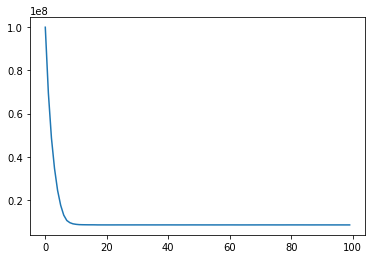

In [98]:
plt.plot(ns)
plt.show()

In [99]:
print(ns[:10], ns[-1])

[100000000, 69555083, 48673248, 34527098, 24380732, 17500105, 12914255, 10430918, 9414568, 8896876] 8387797


In [15]:
print(ns[-2:])

[69422664, 69419484]


In [284]:
error_estimates = estimate_error_rates(is_mendelian, allowable_errors, counts)

Mendelian 63 Nonmendelian 961
Removing zero cols: [(0.0, (0, 1)), (0.0, (2, 1)), (1.0, (0, 1)), (1.0, (2, 1))]
Removing zero rows: 664
(297, 41) (297,)
Estimating... (297, 41) (297,)
optimal


In [314]:
# real?
for err, est in zip(errors, error_estimates):
    print(err, np.log10(est))

(0, 1) [        nan         nan -2.64744162 -2.59979956 -2.44492279 -2.50858512]
(0, 2) [-5.36812984 -4.98241978 -5.90725422 -6.01082534 -5.54629549 -5.34326408]
(0, 3) [-4.83532781 -4.99942982 -6.05148753 -6.04900794 -6.0473484  -6.04849968]
(1, 0) [-2.89037925 -3.45066511 -4.94245277 -5.22514568 -5.6017656  -5.60518498]
(1, 2) [-4.1605741  -4.75810452 -5.84755528 -5.8513972  -5.85469372 -5.853227  ]
(1, 3) [-6.06497718 -6.06859834 -6.06442721 -6.06981054 -6.07118838 -6.07118166]
(2, 0) [-5.84444259 -5.84615624 -5.62252215 -5.78817505 -5.7882394  -5.78596909]
(2, 1) [        nan         nan -5.15723195 -4.93414343 -4.68810944 -4.99541377]
(2, 3) [-4.69747971 -4.80930935 -5.8541749  -5.84925144 -5.84958179 -5.8477715 ]


In [282]:
for err, est in zip(errors, error_estimates):
    print(err, np.log10(est))

(0, 1) [        nan         nan -3.84924433 -3.85059215 -3.82742183]
(0, 2) [-5.650774   -5.65753445 -5.73063416 -5.63225675 -5.77816717]
(0, 3) [-3.51274666 -3.45668455 -3.43534924 -3.53622732 -3.58477007]
(1, 0) [-2.44476691 -2.25470044 -3.3667955  -3.10346758 -3.26260157]
(1, 2) [-3.01832622 -2.97505754 -5.74302098 -5.67044191 -4.38178135]
(1, 3) [-3.1368213  -3.33289731 -3.92280638 -3.95217159 -3.8071885 ]
(2, 0) [-5.80293632 -5.79457236 -4.91852187 -4.84746578 -4.92189257]
(2, 1) [        nan         nan -3.66916519 -3.76343163 -3.53681129]
(2, 3) [-3.6837584  -3.51351517 -3.45580963 -3.47492105 -3.43688596]


In [239]:
for err, est in zip(errors, error_estimates):
    print(err, np.log10(est))

(0, 1) [        nan         nan -2.70546055 -2.64854084 -2.48702049 -2.54356521
 -2.70656741 -2.57876962]
(0, 2) [-6.04817014 -5.00249968 -5.40496882 -6.01319475 -5.71235086 -5.41133547
 -6.01240588 -5.72064522]
(0, 3) [-5.20245504 -5.13917916 -6.05363483 -6.05117472 -6.04952385 -6.0506694
 -6.05171881 -6.05282275]
(1, 0) [-2.88274912 -3.07034598 -4.79415093 -5.1490448  -5.60176298 -5.60522873
 -5.6076282  -5.243729  ]
(1, 2) [-4.18115726 -4.76661454 -5.8475505  -5.85138105 -5.85467729 -5.85321067
 -5.85252347 -5.85044439]
(1, 3) [-6.06498518 -6.06861609 -6.06442417 -6.06980082 -6.07117812 -6.0711716
 -6.07086595 -6.06773719]
(2, 0) [-5.8490044  -5.85084912 -5.79316226 -5.78817507 -5.78823979 -5.78596963
 -5.78437976 -5.78982429]
(2, 1) [        nan         nan -5.09066652 -4.92830628 -4.70475761 -5.0424006
 -5.3241287  -5.25074184]
(2, 3) [-5.55720588 -5.02908417 -5.85417435 -5.84925053 -5.84958121 -5.84777058
 -5.84660372 -5.85004227]
